# Exercises for the course "Declarative Problem Solving Paradigms in AI"

In [1]:
# Imports (some dependency errors may appear, you can ignore them for now)
# !pip install cpmpy numpy colorama networkx matplotlib requests z3-solver --quiet

import cpmpy as cp

## **Session 2: Reification, solving, debugging and explaining**

Welcome to the second exercise session of Declarative Problem Solving Paradigms in AI. In this session, we will cover a collection of concepts you would need to master as to efficiently and effectively create Constraint Programming models of your own:


1) Debugging

2) Solving

3) Explaining

4) Reification

We will cover each of them in a separate section; guiding you through an example, followed by a modelling exercise.

**Useful Resources:**
* CPMpy documentation: https://cpmpy.readthedocs.io/en/latest/index.html
* CPMpy quickstart: https://cpmpy.readthedocs.io/en/latest/modeling.html

### **Part 4: Reification**

In this section, we'll delve deeper into the concept of **reification** within the Constraint Programming (CP) paradigm. In the lecture slides, reification was introduced as something that "*enables the reasoning about the truth of a constraint or a Boolean expression*".

If we have an expression like $(x < y)$, we could directly add it to a model thus enforce it to be $True$ (an inequality constraint over the decision variables `x` and `y`). On the other hand, we can also introduce a new boolean decision variable `b` and use it to instead reify the constraint. The reification is $b \leftrightarrow (x < y)$, which in CPMpy gets written as `b == (x < y)`.

`b` is known as the reified variable. `b` now allows us to reason about the original expression (without necessarily enforcing it).

As seen in the course, reification is a powerfull mechanism that enables:
- higher-level modelling
- efficient reuse of logical components through their reified variable

It allows for modeling techniques such as **"soft constraints"** (where constraints are not enforced, but a penalty is added for their violations) and **"conditional constraints"** (constraints that are only enforced when a certain condition is met, i.e. if another expression evaluates to $True$).


#### Setup

In [2]:
# Support code

import re

import networkx as nx
import matplotlib.pyplot as plt
import requests
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from io import BytesIO
from cpmpy.expressions.utils import flatlist

# Function to download emoji image from the web
def download_emoji(emoji_code):
    response = requests.get(f"https://github.com/twitter/twemoji/raw/master/assets/72x72/{emoji_code}.png")
    return Image.open(BytesIO(response.content)).convert('RGBA')  # Convert to RGBA for transparency support

# Function to convert emoji to unicode code for image link (e.g., 😃 -> 1f603)
def emoji_to_unicode(emoji):
    return '-'.join(f"{ord(c):x}" for c in emoji)

# Function to show a nice graph of the students and their wishes
def show_graph(people, wishes, pos=None, conflict=[], correction=[], satisfiable=[]):
    # Check solution legality
    if pos is not None:
        if len(set(pos)) < len(pos):
            raise ValueError('Two students are standing at the same location, this is not allowed!')

    # Create networkX graph
    G = nx.Graph()
    G.add_nodes_from(list(range(len(people))))
    G.add_edges_from([(who, whom) for (who,whom) in wishes])
    nx_pos = nx.circular_layout(G)

    # Create figure
    fig, ax = plt.subplots()
    nx.draw(G, nx_pos, with_labels=False, node_size=2000, node_color="white", font_size=20, font_color="black", ax=ax)
    nx.draw_networkx_labels(G, nx_pos)

    conflict = flatlist(conflict)
    correction = flatlist(correction)
    satisfiable = flatlist(satisfiable)

    conflict_edges = []
    for c in conflict:
        if c.name == "alldifferent": continue
        n1, n2 = c.args
        if n1.name == "max": continue
        if n1.name == "abs": n1, n2 = n1.args[0].args
        a = int(re.search("\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search("\[[0-9]*\]", str(n2)).group()[1:-1])
        conflict_edges.append((min(a, b), max(a, b)))

    sat_edges = []
    for c in satisfiable:
        if c.name == "alldifferent": continue
        n1, n2 = c.args
        if n1.name == "max": continue
        if n1.name == "abs": n1, n2 = n1.args[0].args
        a = int(re.search("\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search("\[[0-9]*\]", str(n2)).group()[1:-1])
        sat_edges.append((min(a, b), max(a, b)))

    correction_edges = []
    for c in correction:
        if c.name == "alldifferent": continue
        n1, n2 = c.args
        if n1.name == "max": continue
        if n1.name == "abs": n1, n2 = n1.args[0].args
        a = int(re.search("\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search("\[[0-9]*\]", str(n2)).group()[1:-1])
        correction_edges.append((min(a, b), max(a, b)))

    colors = ["red" if (a, b) in conflict_edges else ("green" if (a,b) in sat_edges else ("orange" if (a,b) in correction_edges else "black")) for (a, b) in G.edges()]

    # Color edges
    nx.draw_networkx_edges(G, nx_pos, edgelist=G.edges(), edge_color=colors, width=2, ax=ax)
    if pos is not None: # if a solution position is provided
        green_edges = [wish for wish in wishes if abs(pos[wish[0]] - pos[wish[1]]) == 1]
        nx.draw_networkx_edges(G, nx_pos, edgelist=G.edges(), edge_color='red', width=2, ax=ax)
        nx.draw_networkx_edges(G, nx_pos, edgelist=green_edges, edge_color='green', width=2, ax=ax)

    # Loop through nodes and place emoji images on them
    for node, (x, y) in nx_pos.items():
        emoji_unicode = emoji_to_unicode(people[node])
        emoji_img = download_emoji(emoji_unicode)
        imagebox = OffsetImage(emoji_img, zoom=0.5)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)

    plt.tight_layout()
    plt.show()

#### **1. Alignment Photo Problem**

In this exercise, we'll see how to use reification as a means to post expressions as **soft constraints**.

We'll revisit the "Alignment Photo Problem" from the explanation section. Copy-and-paste your previous implementation below.

In [3]:
def photo_alignment(students, wishes):
    N = len(students)

    # Decision variables
    pos = cp.intvar(0, N-1, shape=N)

    # Model
    model = cp.Model()

    # Constraints
    """
    TODO: Copy-and-paste your previous implementation here.
    """
    model += cp.AllDifferent(pos)
    model += [cp.abs(pos[wish[0]] - pos[wish[1]]) == 1 for wish in wishes]

    # Solve
    sat = model.solve()

    # Show solution
    if sat:
        print("Found a solution:")
        print(f"Student positions: {pos.value()}")
    else:
        print("Problem is UNSAT")

    return model, pos

If we run the problem again on the second set of wishes, we will again get UNSAT.

In [4]:
# Parameters of the problem
students = ["😀", "😇", "😎", "🤠", "🤩", "🧐", "🤕"]
wishes = [(1, 4), (4, 0), (5, 4), (5, 2), (2, 1), (6, 4), (3, 0), (4, 2), (6, 3), (0, 5)] # pairs of indexes into the list of students

model, pos = photo_alignment(students, wishes)

Problem is UNSAT


In the previous section we explained what needed to be corrected (i.e. which wishes would need to be dropped) to make the problem SAT. The result was an MCS; a minimal set of constraints which can be removed from the original problem in order to make it SAT. So now we can manually remove those constraints and the model should become solvable.

An alternative approach would be to use reification. From the MCS we got the insight that we have too many "wishes", resulting in conflicts. Modeling these wishes as "**soft**" instead of "**hard**" constraints and maximizing the number of satisfied wishes, will give a similar result without having to manually start removing constraints.


Re-implement the model, but now make use of **reification** as to **maximize the number of satisfied wishes**.

In [5]:
# Parameters of the problem
students = ["😀", "😇", "😎", "🤠", "🤩", "🧐", "🤕"]
wishes = [(1, 4), (4, 0), (5, 4), (5, 2), (2, 1), (6, 4), (3, 0), (4, 2), (6, 3), (0, 5)] # pairs of indexes into the list of students

def photo_alignment(students, wishes):
    N = len(students)
    M = len(wishes)

    # Decision variables - TODO
    pos = cp.intvar(0, N-1, shape=N)
    """
    TODO: Introduce new reified variables, one for each student wish indicating whether or not it is satisfied.
    """
    # ┌────SOLUTION────┐
    B = cp.boolvar(shape=M) # for each of the "wish"-constraints,
                            # a boolean variable to reify it and make
                            # it a soft-constraint
    # └────────────────┘

    # Model
    model = cp.Model()

    # Constraints - TODO
    """
    TODO: Fill in the constraints according to the problem description whilst maximizing the number of satisfied student wishes.

    HINT: Reify the student wishes and maximize the number of 'true' reified variables.
    """

    model += cp.AllDifferent(pos) # only one student can stand at each location
    model += [b == (cp.abs(pos[wish[0]] - pos[wish[1]]) == 1) for (wish, b) in zip(wishes, B)]

    # Objective - TODO
    """
    TODO: Maximize the number of satisfied wishes.
    """
    model.maximize(cp.sum(B)) # Update the argument

    # Solve
    sat = model.solve()

    # Show solution
    if sat:
        print("Found a solution:")
        print(f"Student positions: {pos.value()}")
        print(f"{sum([abs(pos.value()[who] - pos.value()[whom]) == 1 for (who, whom) in wishes])} satisfied wishes")
    else:
        print("Problem is UNSAT")

    return model, pos

model, pos = photo_alignment(students, wishes)

Found a solution:
Student positions: [3 0 1 4 6 2 5]
6 satisfied wishes


How many wishes were you able to satisfy? It should be 6.

If the solution looks good, we can again try to visualize it as a graph:

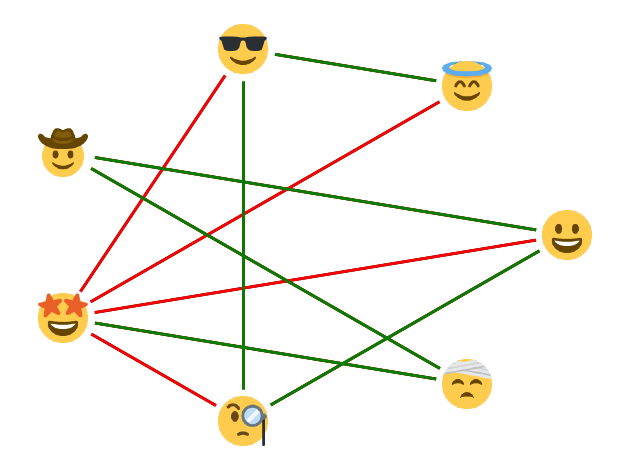

In [6]:
show_graph(students, wishes, pos=pos.value())

4 wishes will need to be compromised on, the exact same conclusion as we made in the 'Explaining' section when using an MCS. We just implemented the "wishes" as **soft constraints**. The reification allowed us to reason over these constraints and maximize the amount of satisfied ones.

I hope you can see the parallels between both approaches we took to make the problem satisfiable; calculating an MSS/MCS to see/explain which constraints need to be dropped manually OR reifying the constraints and having a "higher-level" model that reasons over these soft-constraints and tries to satisfy as many of them as possible.

This parallel was to be expected, because many of the explanation techniques actually make use of reification in their algorithms because it allows us to "reason" over constraints.



#### **2. Task allocation problem**:

In this exercise, we'll see how to use reification for modeling **conditional constraints**.

Your goal is to assign workers to tasks such that:

- Each task is assigned to exactly one worker.
- Each worker can be assigned to maximally one task.
- Additional conditional rules between worker-task assignments must be respected.

**Conditional Constraints**:

- If worker 0 is assigned to task 0, then worker 1 cannot be assigned to task 2.
- If worker 1 is assigned to task 1, then worker 2 must be assigned to task 0.
- If worker 2 is assigned to task 2, then worker 0 cannot be assigned to task 1.



In the "Debugging" section, we fixed the model for the "Organizing the Harmony Festival" problem. There we had a collection of conditional constraints of the type $a \rightarrow b$ (i.e. if $a$ is $True$ then $b$ must be $True$). In CPMpy this gets modeled using `a.implies(b)`. In that exercise, `a` and `b` were boolean decision variables.

Looking at the current problem, the expressions inside the implication are now assignment expression, i.e. $(\text{worker 0 is assigned to task 0}) \rightarrow (\text{worker 1 not on task 2})$.

Will this still work?


In [7]:
# Parameters of the problem
n_tasks = 3        # Number of tasks
n_workers = 3      # Number of workers

# Decision Variables - TODO
"""
TODO: Finish the set of decision variables representing which task gets assigned to which worker.
"""
task_assignment = cp.intvar(1, n_workers, shape=n_tasks, name="task_assignment") # task_assignment[j] == i iff worker i is assigned to task j


# Model
model = cp.Model()

# Constraints - TODO
"""
TODO: Fill in the constraints according to the problem description.
"""
# 1) Each task is assigned to exactly one worker.
# -> no need to model this constraint, since the chosen encoding for 'task_assignment'
#    will already enforce this (each task j can only have one worker task_assignment[j] as value)
# 2) Each worker can be assigned to maximally one task.
model += cp.AllDifferent(task_assignment)


# Reification & Conditional constraints - TODO
"""
TODO: Model the conditional constraints, i.e. how the truth value of one expression
      determines if another expression gets enforced as a constraint;
      e.g. condition_expression -> conditionally_enforced_expression

HINT: We've seen in the lectures that CPMpy can automatically create reified variables for us,
      giving us the ability to directly formulate the conditional implication between the two expressions.
      A benefit of using a high-level modeling language!

HINT: Use half-implications 'a -> b' (a.implies(b) in CPMpy).
      e.g. ( <worker 0 is assigned to task 0> ).implies( <worker 1 not on task 2> )
"""
model += (task_assignment[0] == 0).implies(task_assignment[2] != 1)
model += (task_assignment[1] == 1).implies(task_assignment[0] == 2)
model += (task_assignment[2] == 2).implies(task_assignment[1] != 0)

# Solve the model
sat = model.solve()

# Print result
if sat:
    print("Task assignments:", task_assignment.value())
else:
    print("No solution found.")

Task assignments: [1 3 2]


Check if your solution indeed satisfies all the conditional constraints.

How does reification now come into play for this model? We've directly formulated the conditional implications between two expression. As seen in the lectures, this is a high-level modeling feature of CPMpy. Under the hood, reified variables get created and the nested "implied" expression gets automatically reified. Fill in one of your "conditional implication constraints" from above and see how CPMpy transforms it for you.

In [8]:
from cpmpy.transformations.flatten_model import flatten_constraint
"""
TODO: Fill in one of your "Conditional implications" and see how CPMpy reifies to for you.
"""
# flatten_constraint( (...).implies(...) )
flatten_constraint( (task_assignment[0] == 0).implies(task_assignment[2] != 1) )

[(task_assignment[0] == 0) -> (BV13), (task_assignment[2] != 1) == (BV13)]

Note how CPMpy reified the "implied" expression and then re-used the newly created reified boolean variable in the original implication.

This exercise was an application of **"Conditional Constraints"**, another modeling technique made possible by reification.